In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split
import random

In [2]:
geyser = pd.read_csv("geyser.csv")
chips = pd.read_csv("chips.csv")

In [3]:
geyser.head()

,x,y,class
0,1,4.4,N
1,1,3.9,N
2,1,4.0,P
3,1,4.0,N
4,1,3.5,N


In [4]:
chips.head()

,x,y,class
0,0.051267,0.69956,P
1,-0.092742,0.68494,P
2,-0.213710,0.69225,P
3,-0.375000,0.50219,P
4,-0.513250,0.46564,P


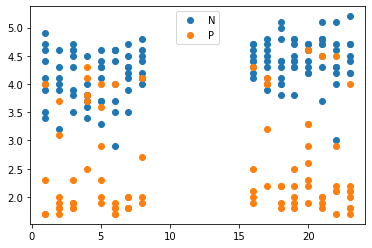

In [5]:
groups = geyser.groupby('class')

fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', label=name)
ax.legend()

plt.show()

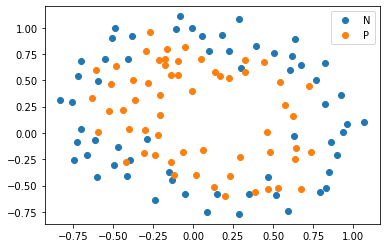

In [6]:
groups = chips.groupby('class')

fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', label=name)
ax.legend()

plt.show()

In [7]:
geyser.loc[geyser["class"] == "N", "class"] = -1
geyser.loc[geyser["class"] == "P", "class"] = 1

In [8]:
chips.loc[chips["class"] == "N", "class"] = -1
chips.loc[chips["class"] == "P", "class"] = 1

In [21]:
class SMO:
    def __init__(self, C=1, toler=0.001, kernel="lin", sigma=0.5, degree=3):
        self.C = C
        self.tol = toler
        self.degree = 1
        self.b = 0

        if kernel == 'lin':
            self.K = self.polynomial_kernel
        elif kernel == 'poly':
            self.degree = degree
            self.K = self.polynomial_kernel
        elif kernel == 'rbf':
            self.sigma = sigma
            self.K = self.gaussian_kernel           
        else:
            print("There is no such kernel")

    def gaussian_kernel(self, x1, x2):
        norm = np.linalg.norm(np.subtract(x1, x2)) 

        return np.exp(-(norm ** 2) / (2 * (self.sigma ** 2)))

    def polynomial_kernel(self, x1, x2):
        dot_product = np.dot(np.transpose(x1), x2) 

        return (dot_product + 1) ** self.degree

    def E(self, i):
        if (self.alphas[i] > 0) and (self.alphas[i] < self.C):
            return self.e_cache[i]
        
        u = 0
        for j in range(self.m):
            u += self.K(self.X[j], self.X[i]) * self.y[j] * self.alphas[j]
        u -= self.b
        
        return u - self.y[i]

    def take_step(self, i1, i2):
        if i1 == i2:
            return 0
        alpha1 = self.alphas[i1]
        y1 = self.y[i1]
        E1 = self.E(i1)
        
        alpha2 = self.alphas[i2]
        y2 = self.y[i2]
        E2 = self.E(i2)
        
        s = y1 * y2
        
        if y1 == y2:
            L = max(0, alpha1 + alpha2 - self.C)
            H = min(self.C, alpha1 + alpha2)
        else:
            L = max(0, alpha2 - alpha1)
            H = min(self.C, self.C + alpha2 - alpha1)
        
        if L == H:
            return 0
        
        eta = self.K(self.X[i1], self.X[i1]) + self.K(self.X[i2], self.X[i2]) - 2 * self.K(self.X[i1], self.X[i2])
        if eta > 0:
            a2 = alpha2 + y2 * (E1 - E2) / eta
            if a2 < L:
                a2 = L
            elif a2 > H:
                a2 = H
        else:
            c1 = eta / 2.0
            c2 = y2 * (E1 - E2) - eta * alpha2
            Lobj = c1 * L * L + c2 * L
            Hobj = c1 * H * H + c2 * H
            if Lobj < Hobj - self.tol:
                a2 = L
            elif Lobj > Hobj + self.tol:
                a2 = H
            else:
                a2 = alpha2
                
        if abs(a2 - alpha2) < self.tol * (a2 + alpha2 + self.tol):
            return 0
        
        a1 = alpha1 + s * (alpha2 - a2)
        if a1 > 0 and a1 < self.C:
            bnew = self.b + E1 + y1 * (a1 - alpha1) * self.K(self.X[i1], self.X[i1]) + y2 * (a2 - alpha2) * self.K(self.X[i1], self.X[i2])
        elif a2 > 0 and a2 < self.C:
            bnew = self.b + E2 + y1 * (a1 - alpha1) * self.K(self.X[i1], self.X[i2]) + y2 * (a2 - alpha2) * self.K(self.X[i2], self.X[i2])
        else:
            b1 = self.b + E1 + y1 * (a1 - alpha1) * self.K(self.X[i1], self.X[i1]) + y2 * (a2 - alpha2) * self.K(self.X[i1], self.X[i2])
            b2 = self.b + E2 + y1 * (a1 - alpha1) * self.K(self.X[i1], self.X[i2]) + y2 * (a2 - alpha2) * self.K(self.X[i2], self.X[i2])
            bnew = (b1 + b2) / 2.0
            
        t1 = y1 * (a1 - alpha1)
        t2 = y2 * (a2 - alpha2)
        dw = bnew - self.b
        
        for i in range(self.m):
            if (self.alphas[i] > 0) and (self.alphas[i] < self.C):
                self.e_cache[i] += t1 * self.K(self.X[i1], self.X[i]) + t2 * self.K(self.X[i2], self.X[i]) - dw
                
        self.e_cache[i1] = 0
        self.e_cache[i2] = 0
        
        self.b = bnew
        self.alphas[i1] = a1
        self.alphas[i2] = a2
        return 1
        
    def examine_example(self, i2):
        y2 = self.y[i2]
        alpha2 = self.alphas[i2]
        E2 = self.E(i2)
        r2 = E2 * y2
        
        if ((r2 < -self.tol) and (alpha2 < self.C)) or ((r2 > self.tol) and (alpha2 > 0)):
            max_delta_E = 0
            i1 = -1
            for i in range(self.m):
                if self.alphas[i] > 0 and self.alphas[i] < self.C:
                    E1 = self.e_cache[i]
                    delta_E = abs(E1 - E2)
                    if delta_E > max_delta_E:
                        max_delta_E = delta_E
                        i1 = i
            if i1 >= 0:
                if self.take_step(i1, i2):
                    return 1
            
            random_index = np.random.permutation(self.m)
            for i1 in random_index:
                if self.alphas[i1] > 0 and self.alphas[i1] < self.C:
                    if self.take_step(i1, i2):
                        return 1
            
            random_index = np.random.permutation(self.m)
            for i1 in random_index:
                if self.take_step(i1, i2):
                    return 1
        return 0

    def main_routine(self):
        num_changed = 0
        examine_all = 1
        while (num_changed > 0 or examine_all):
            num_changed = 0
            if (examine_all == 1):
                for i2 in range(self.m):
                    num_changed += self.examine_example(i2)
            else:
                for i2 in range(self.m):
                    if (self.alphas[i2] > 0) and (self.alphas[i2] < self.C):
                        num_changed += self.examine_example(i2)
            if (examine_all == 1):
                examine_all = 0
            elif (num_changed == 0):
                examine_all = 1
                
    def fit(self, X, y):
        self.X = X
        self.y = y
        self.m = np.shape(X)[0]
        self.n = np.shape(X)[1]
        self.alphas = np.zeros(self.m)
        self.e_cache = np.zeros(self.m)
        self.main_routine()
            
    def predict(self, X):
        result = []
        
        for i in range(X.shape[0]):
            u = 0
            for j in range(self.m):
                u += self.K(self.X[j], X[i]) * self.y[j] * self.alphas[j]
            u -= self.b
        
            result.append(u)
            
        return np.array(result)

# 1) geyser

In [11]:
X = geyser.drop("class", axis=1)
y = geyser["class"]

In [12]:
X = X.values
y = y.values

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [14]:
best_score = 0
best_kernel = ''
best_C = 0
for C in [0.01, 0.5, 1, 2, 5, 10, 50, 100, 200, 500, 1000, 2000, 5000]:
    for kernel in ['rbf', 'lin', 'poly']:   
        smo = SMO(C=C, kernel=kernel)
        smo.fit(X_train, y_train)
        a = smo.predict(X_test)

        y_pred = np.sign(a)  
        if accuracy_score(y_pred, y_test) > best_score:
            best_score = accuracy_score(y_pred, y_test)
            best_kernel = kernel
            best_C = C

In [15]:
best_score

0.9594594594594594

In [16]:
best_C

0.01

In [17]:
best_kernel

'lin'

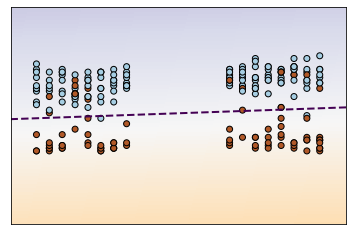

In [86]:
xx, yy = np.meshgrid(np.linspace(-5, 30, 500),
                     np.linspace(-15, 20, 500))
np.random.seed(0)

clf = SMO(C=best_C, kernel=best_kernel)
clf.fit(X, y)

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()), aspect='auto',
           origin='lower', cmap=plt.cm.PuOr_r)

contours = plt.contour(xx, yy, Z, levels=[0], linewidths=2,
                       linestyles='dashed')

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired,
            edgecolors='k')
plt.xticks(())
plt.yticks(())
plt.axis([-1, 25, -1, 7])
plt.show()

# 2) chips

In [87]:
X = chips.drop("class", axis=1)
y = chips["class"]

In [88]:
X = X.values
y = y.values

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [90]:
best_score = 0
best_kernel = ''
best_C = 0
for C in [0.01, 0.5, 1, 2, 5, 10, 50, 100, 200, 500, 1000, 2000, 5000]:
    for kernel in ['rbf', 'lin', 'poly']:
        smo = SMO(C=C, kernel=kernel)
        smo.fit(X_train, y_train)
        a = smo.predict(X_test)

        y_pred = np.sign(a)  
        if accuracy_score(y_pred, y_test) > best_score:
            best_score = accuracy_score(y_pred, y_test)
            best_kernel = kernel
            best_C = C

In [91]:
best_score

0.8205128205128205

In [92]:
best_C

100

In [93]:
best_kernel

'poly'

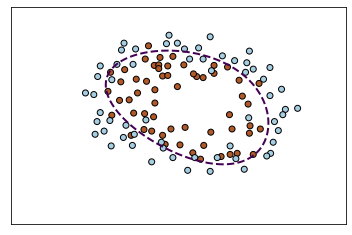

In [105]:
xx, yy = np.meshgrid(np.linspace(-3, 3, 500),
                     np.linspace(-3, 3, 500))
np.random.seed(0)

clf = SMO(C=best_C, kernel=best_kernel)
clf.fit(X, y)

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

contours = plt.contour(xx, yy, Z, levels=[0], linewidths=2,
                       linestyles='dashed')

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired,
            edgecolors='k')
plt.xticks(())
plt.yticks(())
plt.axis([-1.5, 1.5, -1.5, 1.5])
plt.show()